In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import MinMaxScaler
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import dash_bootstrap_components as dbc
from dash_bootstrap_templates import load_figure_template, ThemeChangerAIO, ThemeSwitchAIO
from sklearn.metrics import mean_squared_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster

Import and Exploration

In [2]:
# Import the ProjectTweets_3.csv file
df = pd.read_csv('C:/Users/Paul/Downloads/ProjectTweets_3.csv')
df.head()


,full_date,sentiment_score
0,Mon Apr 06 2009,0.000
1,Mon Apr 06 2009,0.500
2,Mon Apr 06 2009,0.200
3,Mon Apr 06 2009,-0.625
4,Mon Apr 06 2009,0.200


In [3]:
# Perform comprehensive EDA

# Check the shape of the dataframe
df.shape

(1598314, 2)

C:\Users\Paul\AppData\Local\Temp\ipykernel_28100\937117552.py:23: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()
C:\Users\Paul\AppData\Local\Temp\ipykernel_28100\937117552.py:26: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.skew()
C:\Users\Paul\AppData\Local\Temp\ipykernel_28100\937117552.py:29: FutureWarning: The default value of numeric_only in DataFrame.kurt is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.kurt

array([[<Axes: title={'center': 'sentiment_score'}>]], dtype=object)

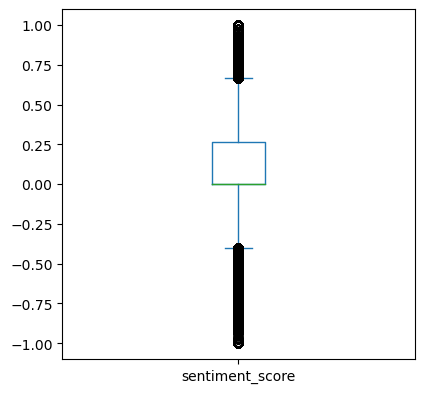

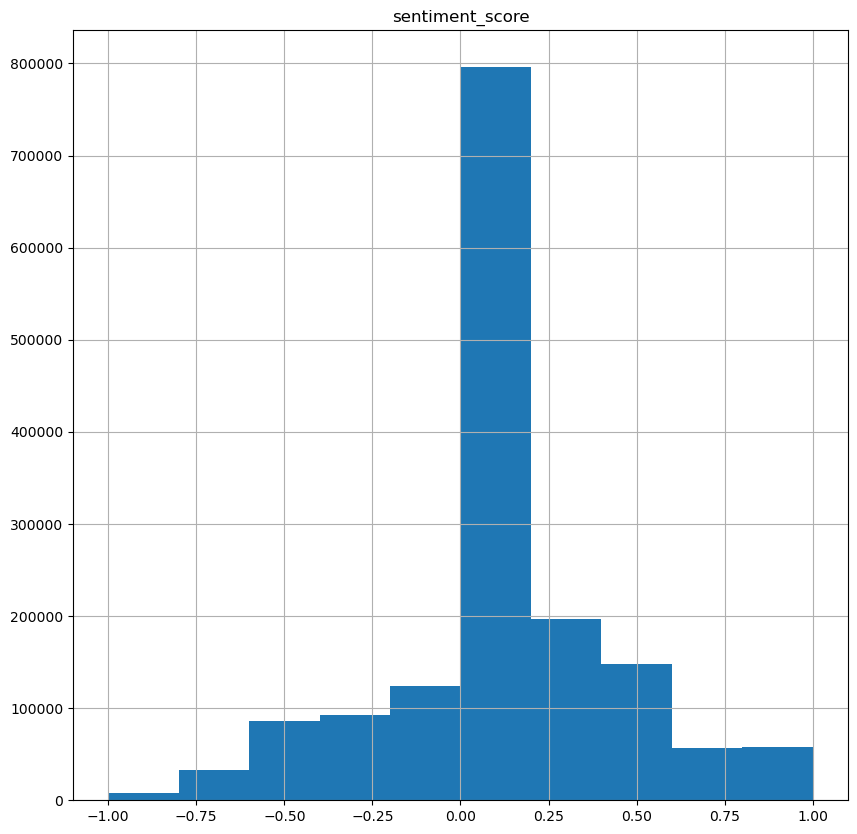

In [4]:
# Check the columns of the dataframe
df.columns

# Check the datatypes of the columns
df.dtypes

# Check the missing values
df.isnull().sum()

# Check the unique values of the columns
df.nunique()

# Check the value counts of the columns
df['sentiment_score'].value_counts()

# Check the percentage of the value counts of the columns
df['sentiment_score'].value_counts(normalize=True)

# Check the summary statistics of the dataframe
df.describe(include='all')

# Check the correlation
df.corr()

# Check the skewness
df.skew()

# Check the kurtosis
df.kurtosis()

# Check the outliers
df.plot(kind='box', subplots=True, layout=(2,2), figsize=(10,10))

# Check the distribution of the columns
df.hist(figsize=(10,10))


In [5]:
# Convert the full_date column to datetime datatype
df['full_date'] = pd.to_datetime(df['full_date'])

# Create the missing dates between the earliest date and the latest date
missing_dates = pd.date_range(start=df['full_date'].min(), end=df['full_date'].max()).difference(df['full_date'])

# Check the number of missing dates
len(missing_dates)

# Add the missing dates to the dataframe, and set the sentiment_score to Null
for date in missing_dates:
    df = df.append({'full_date': date, 'sentiment_score': np.nan}, ignore_index=True)

C:\Users\Paul\AppData\Local\Temp\ipykernel_28100\741361527.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'full_date': date, 'sentiment_score': np.nan}, ignore_index=True)
C:\Users\Paul\AppData\Local\Temp\ipykernel_28100\741361527.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'full_date': date, 'sentiment_score': np.nan}, ignore_index=True)
C:\Users\Paul\AppData\Local\Temp\ipykernel_28100\741361527.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'full_date': date, 'sentiment_score': np.nan}, ignore_index=True)
C:\Users\Paul\AppData\Local\Temp\ipykernel_28100\741361527.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

In [6]:
# Print the rows of the dataframe where the sentiment_score is Null
df[df['sentiment_score'].isnull()]      

,full_date,sentiment_score
1598314,2009-04-08,NaT
1598315,2009-04-09,NaN
1598316,2009-04-10,NaN
1598317,2009-04-11,NaN
1598318,2009-04-12,NaN
1598319,2009-04-13,NaN
1598320,2009-04-14,NaN
1598321,2009-04-15,NaN
1598322,2009-04-16,NaN
1598323,2009-04-22,NaN


Aggregation and Interpolation

In [7]:
# Group the dataframe by full_date and calculate the mean of the sentiment_score
df = df.groupby('full_date').mean().reset_index()

In [8]:
# Check the dataframe
df.head()

,full_date,sentiment_score
0,2009-04-06,0.095282
1,2009-04-07,0.098793
2,2009-04-08,NaN
3,2009-04-09,NaN
4,2009-04-10,NaN


In [9]:
# Fill in the null values using interpolation
df['sentiment_score'] = df['sentiment_score'].interpolate(method='linear')

Exploration of Resultant DF

C:\Users\Paul\AppData\Local\Temp\ipykernel_28100\1118766097.py:9: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all')
C:\Users\Paul\AppData\Local\Temp\ipykernel_28100\1118766097.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()
C:\Users\Paul\AppData\Local\Temp\ipykernel_28100\1118766097.py:11: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.skew()
C:\User

sentiment_score    Axes(0.125,0.53;0.352273x0.35)
dtype: object

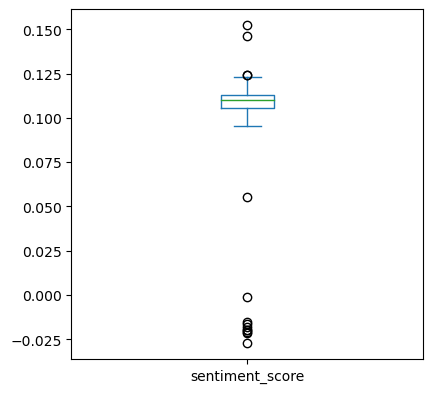

In [10]:
# Perform EDA on the new dataframe
df.shape
df.columns
df.dtypes
df.isnull().sum()
df.nunique()
df['sentiment_score'].value_counts()
df['sentiment_score'].value_counts(normalize=True)
df.describe(include='all')
df.corr()
df.skew()
df.kurtosis()
df.plot(kind='box', subplots=True, layout=(2,2), figsize=(10,10))


In [11]:
# Describe the df
df.describe(include='all')

C:\Users\Paul\AppData\Local\Temp\ipykernel_28100\2175739720.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all')


,full_date,sentiment_score
count,81,81.000000
unique,81,NaN
top,2009-04-06 00:00:00,NaN
freq,1,NaN
first,2009-04-06 00:00:00,NaN
last,2009-06-25 00:00:00,NaN
mean,NaN,0.096523
std,NaN,0.042105
min,NaN,-0.027289
25%,NaN,0.105577


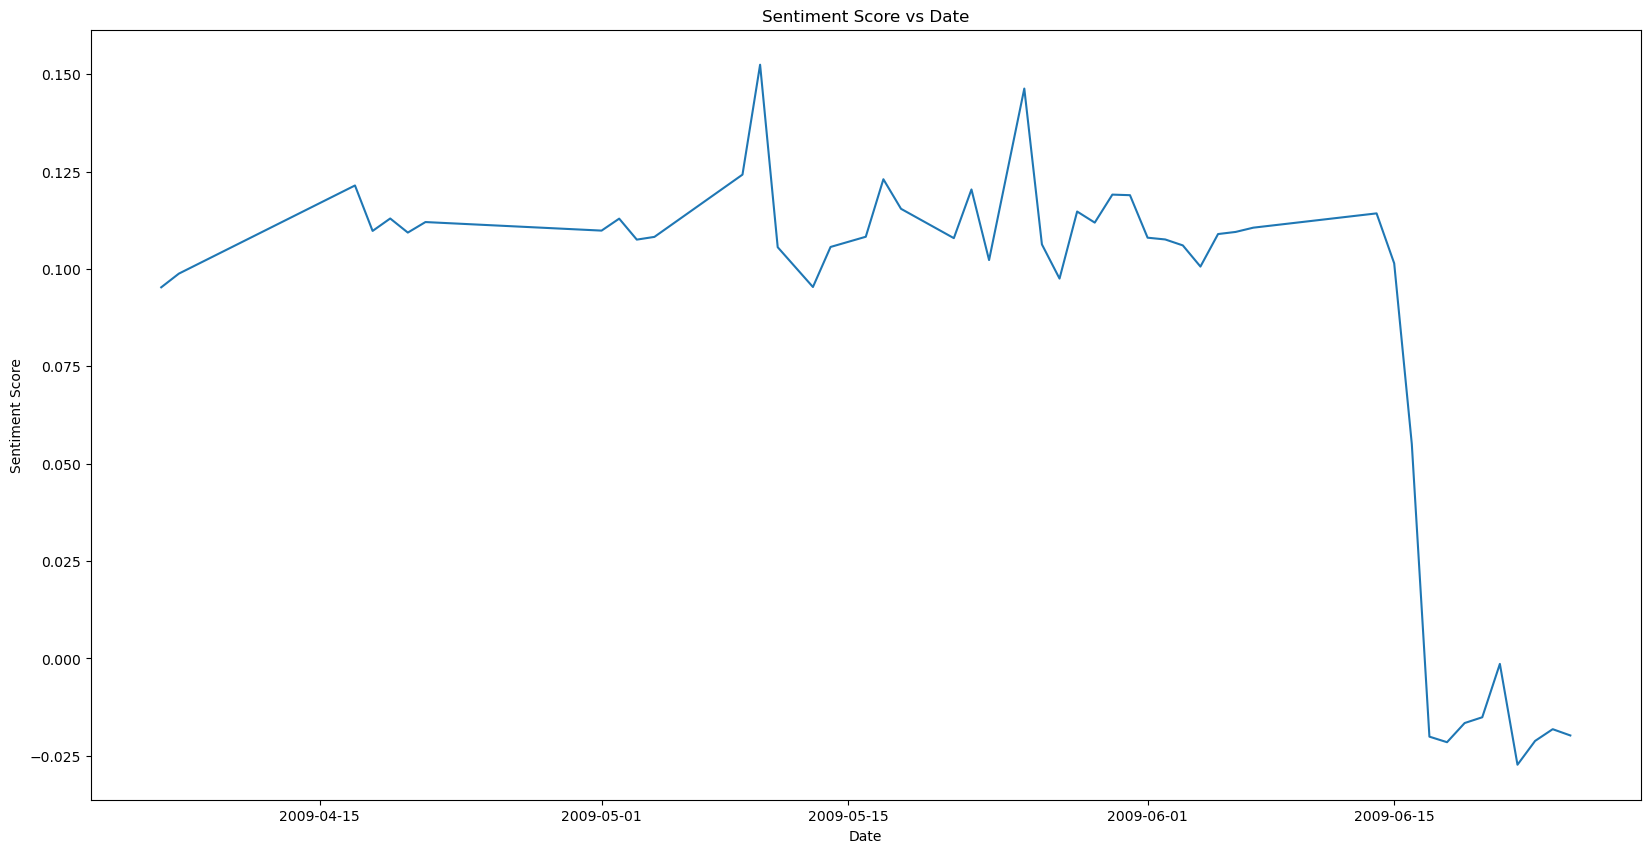

In [12]:
# Plot the sentiment_score
plt.figure(figsize=(20,10))
plt.plot(df['full_date'], df['sentiment_score'])
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Score vs Date')
plt.show()


Time Series Analysis

1. ARIMA

In [14]:
# Create a function to check the stationarity of the time series
def check_stationarity(timeseries):
    
    # Calculate the rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # Plot the rolling statistics
    plt.figure(figsize=(20,10))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.xlabel('Date')
    plt.ylabel('Sentiment Score')
    plt.title('Rolling Mean & Rolling Standard Deviation')
    plt.legend()
    plt.show()
    
    # Perform the Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    # Print whether the time series is stationary or not, based on the p-value
    if dfoutput[1] <= 0.05:
        print('The time series is stationary.')
    else:
        print('The time series is not stationary.')

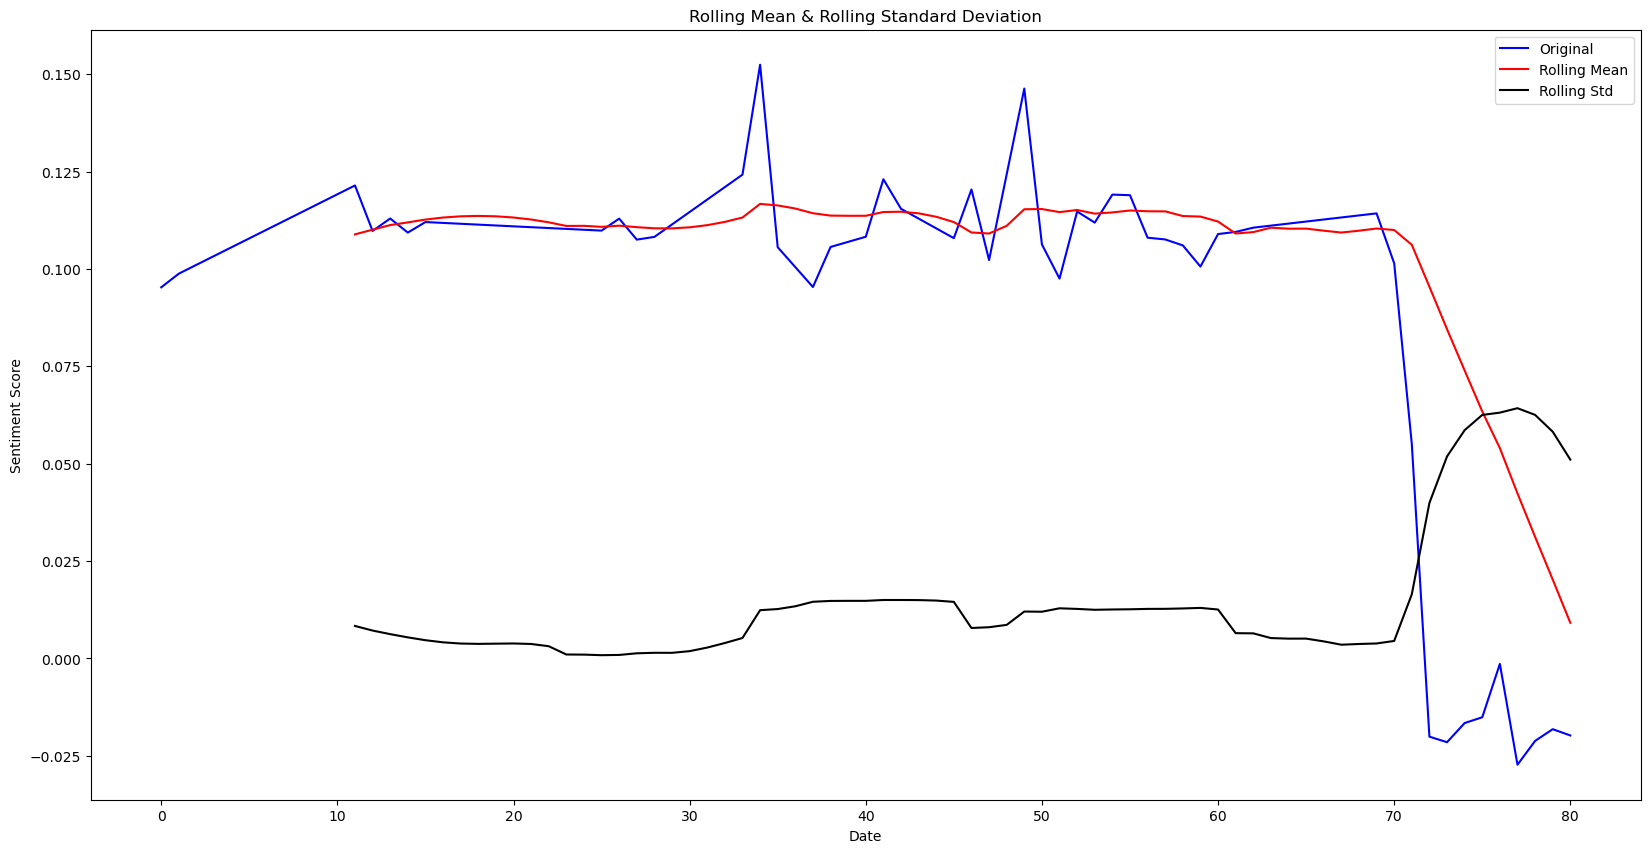

Results of Dickey-Fuller Test:
Test Statistic                 -0.244127
p-value                         0.933053
#Lags Used                      0.000000
Number of Observations Used    80.000000
Critical Value (1%)            -3.514869
Critical Value (5%)            -2.898409
Critical Value (10%)           -2.586439
dtype: float64
The time series is not stationary.


In [15]:
# Check the stationarity of the time series
check_stationarity(df['sentiment_score'])

In [16]:
# Make the time series stationary by differencing
df['sentiment_score_diff'] = df['sentiment_score'] - df['sentiment_score'].shift(1)

In [17]:
# Count the number of missing values in the new column
df['sentiment_score_diff'].isnull().sum()

1

In [18]:
# Show the row where the sentiment_score_diff is Null
df[df['sentiment_score_diff'].isnull()]

,full_date,sentiment_score,sentiment_score_diff
0,2009-04-06,0.095282,NaN


In [19]:
# Fill the Null value with the mean of the column
df['sentiment_score_diff'] = df['sentiment_score_diff'].fillna(df['sentiment_score_diff'].mean())

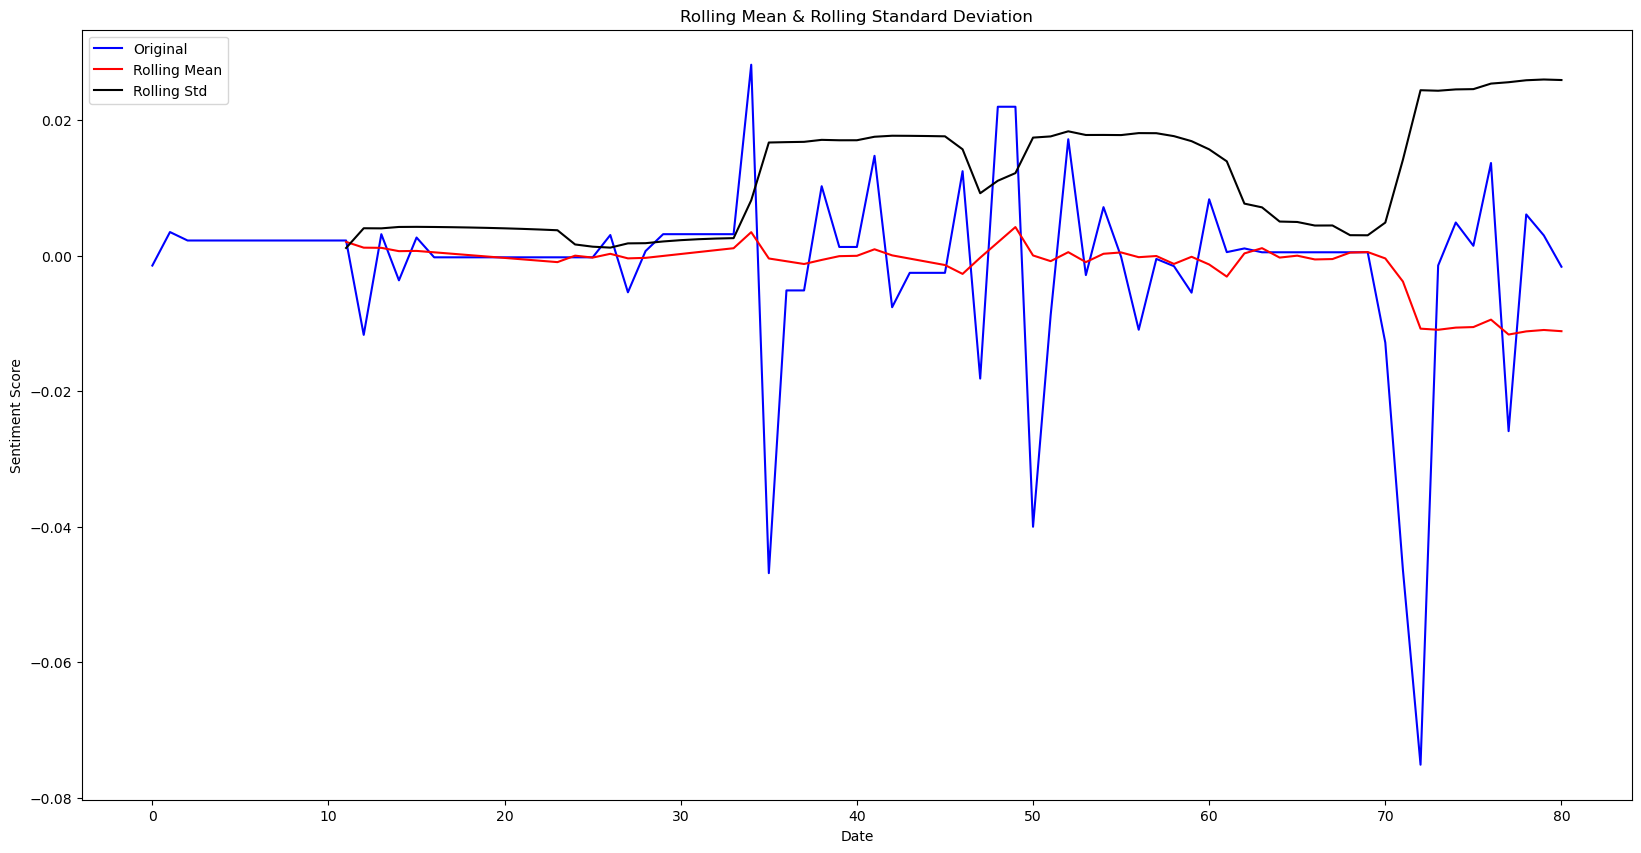

Results of Dickey-Fuller Test:
Test Statistic                -8.043136e+00
p-value                        1.824254e-12
#Lags Used                     0.000000e+00
Number of Observations Used    8.000000e+01
Critical Value (1%)           -3.514869e+00
Critical Value (5%)           -2.898409e+00
Critical Value (10%)          -2.586439e+00
dtype: float64
The time series is stationary.


In [20]:
# Check the stationarity of the time series
check_stationarity(df['sentiment_score_diff'])

In [21]:
# Decompose the time series
# Decomposition is a useful technique to remove the trend and seasonality from a time series, since the timespan is 2.5 months (75 days), the period is 7 days
decomposition = seasonal_decompose(df['sentiment_score'], period=7)
decomposition_diff = seasonal_decompose(df['sentiment_score_diff'], period=7)


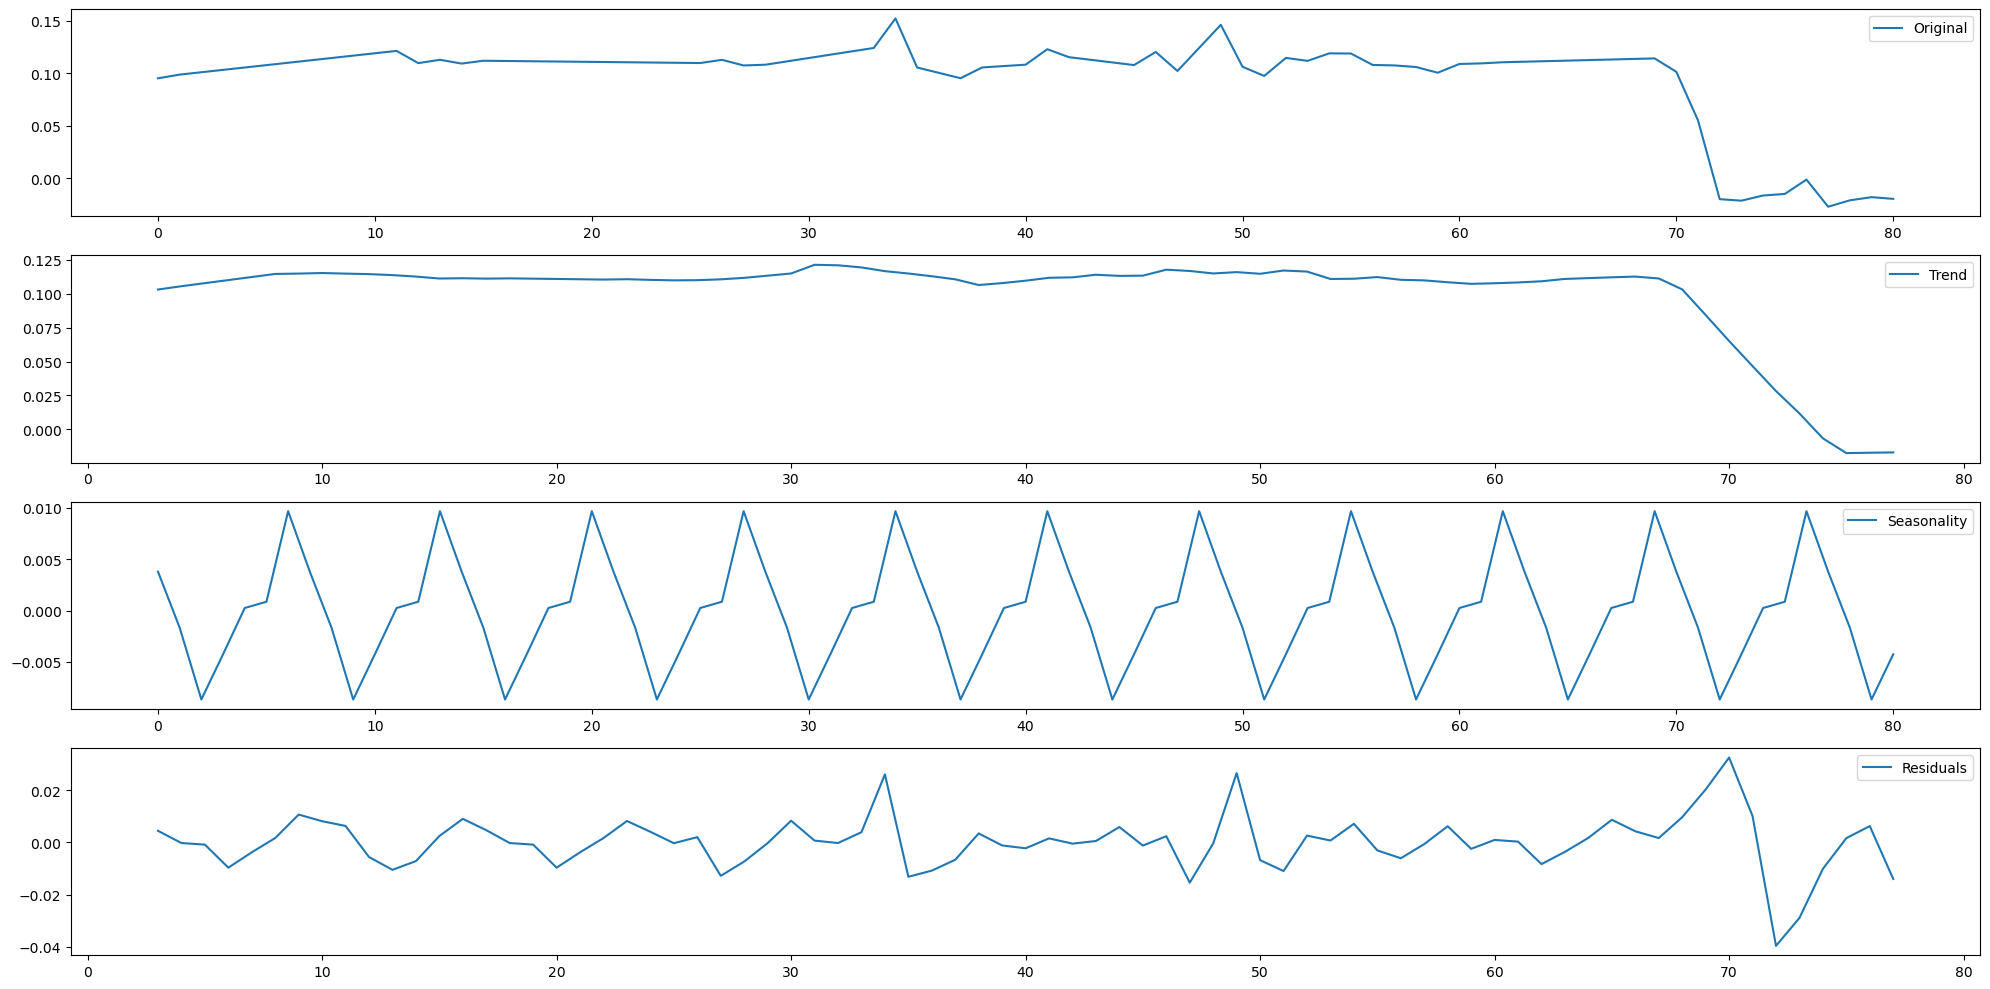

In [22]:
# Plot the original time series, the trend, the seasonality, and the residuals
plt.figure(figsize=(20,10))
plt.subplot(411)
plt.plot(df['sentiment_score'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


In [23]:
# Use the decomposed time series to make the time series stationary
df['sentiment_score_decomposed'] = decomposition.resid
df['sentiment_score_diff_decomposed'] = decomposition_diff.resid

In [24]:
# Fill any null values with the mean of the column
df['sentiment_score_decomposed'] = df['sentiment_score_decomposed'].fillna(df['sentiment_score_decomposed'].mean())
df['sentiment_score_diff_decomposed'] = df['sentiment_score_diff_decomposed'].fillna(df['sentiment_score_diff_decomposed'].mean())

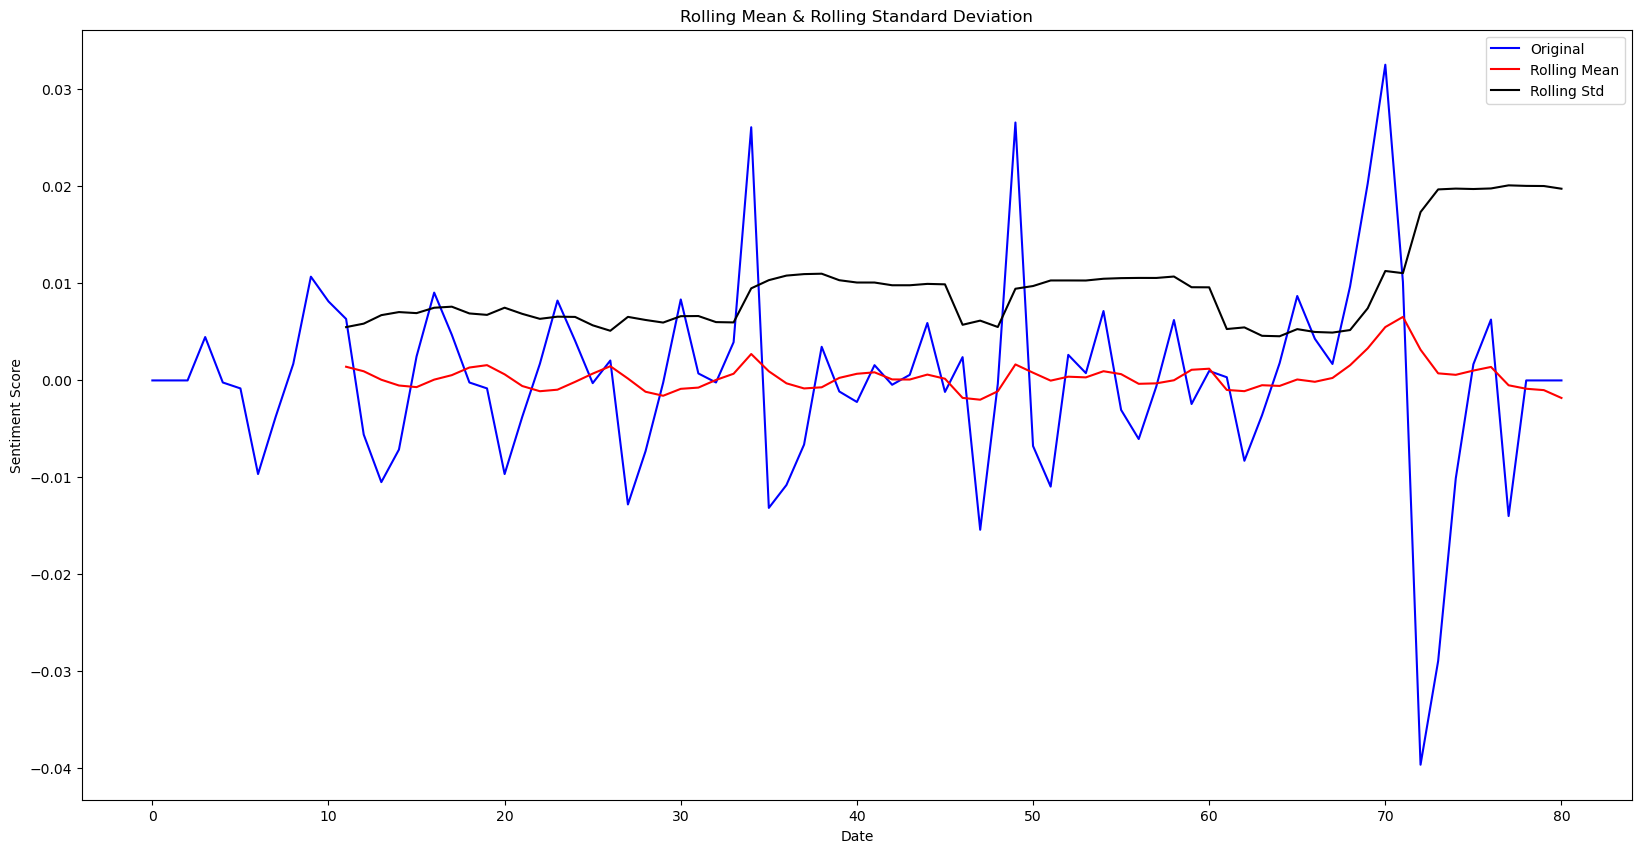

Results of Dickey-Fuller Test:
Test Statistic                -7.650430e+00
p-value                        1.795377e-11
#Lags Used                     1.000000e+00
Number of Observations Used    7.900000e+01
Critical Value (1%)           -3.515977e+00
Critical Value (5%)           -2.898886e+00
Critical Value (10%)          -2.586694e+00
dtype: float64
The time series is stationary.


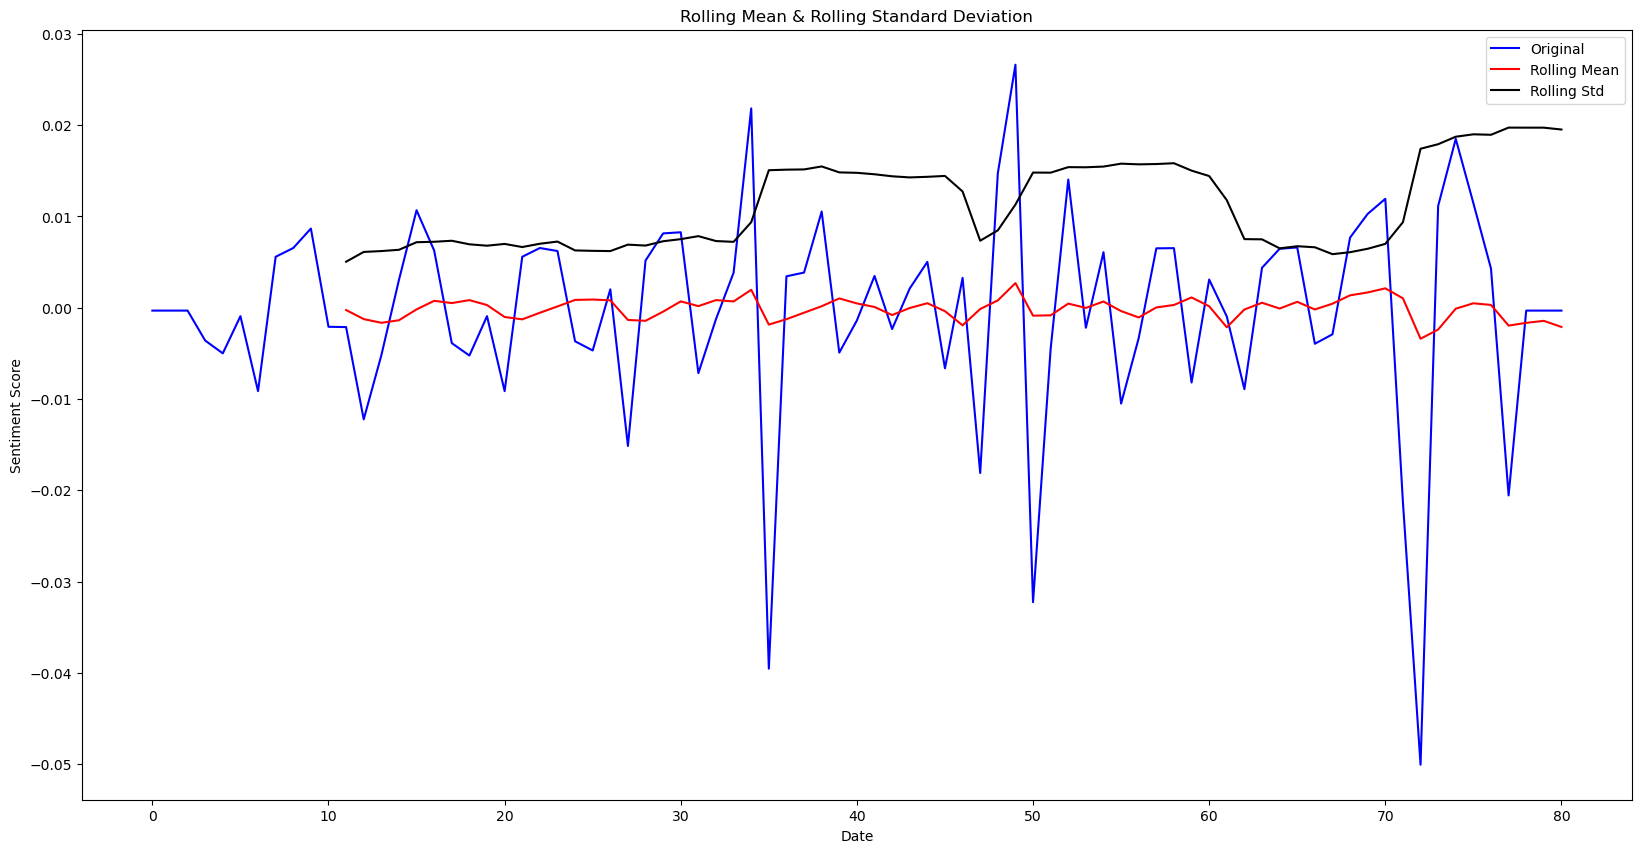

Results of Dickey-Fuller Test:
Test Statistic                -6.188890e+00
p-value                        6.192000e-08
#Lags Used                     6.000000e+00
Number of Observations Used    7.400000e+01
Critical Value (1%)           -3.521980e+00
Critical Value (5%)           -2.901470e+00
Critical Value (10%)          -2.588072e+00
dtype: float64
The time series is stationary.


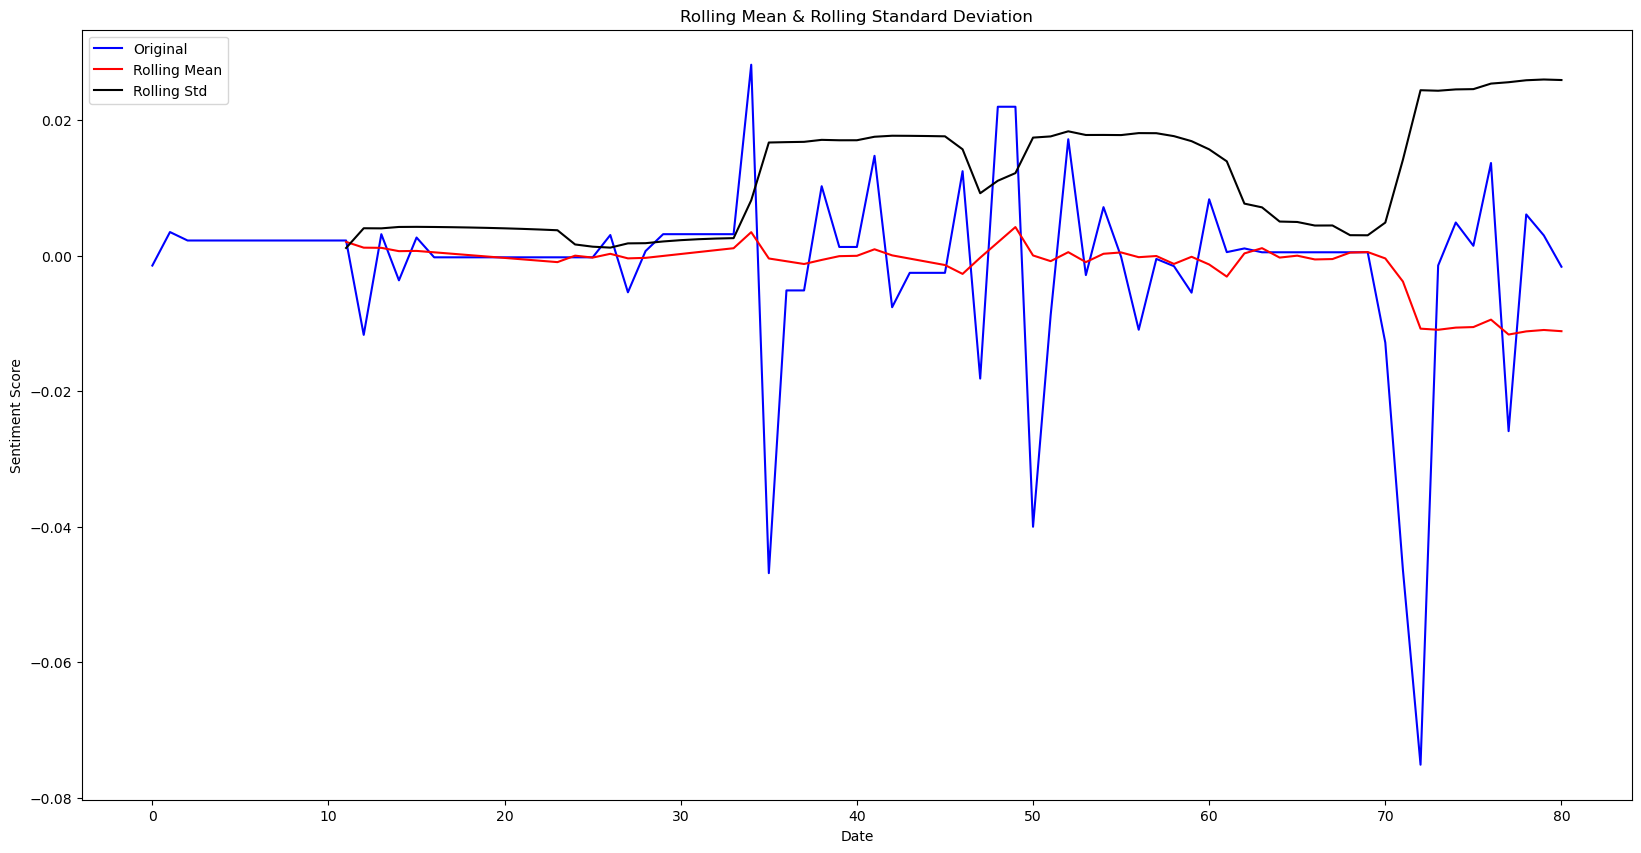

Results of Dickey-Fuller Test:
Test Statistic                -8.043136e+00
p-value                        1.824254e-12
#Lags Used                     0.000000e+00
Number of Observations Used    8.000000e+01
Critical Value (1%)           -3.514869e+00
Critical Value (5%)           -2.898409e+00
Critical Value (10%)          -2.586439e+00
dtype: float64
The time series is stationary.


In [25]:
# Out of the 3 stationary time series columns which one is the most stationary?
check_stationarity(df['sentiment_score_decomposed'])
check_stationarity(df['sentiment_score_diff_decomposed'])
check_stationarity(df['sentiment_score_diff'])

In [26]:
# Create a fuction to plot the ACF and PACF plots
def plot_acf_pacf(timeseries):
    plt.figure(figsize=(20,10))
    plt.subplot(211)
    plt.plot(acf(timeseries, nlags=20))
    plt.axhline(y=0, linestyle='--', color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(timeseries)), linestyle='--', color='gray')
    plt.axhline(y=1.96/np.sqrt(len(timeseries)), linestyle='--', color='gray')
    plt.title('Autocorrelation Function')
    plt.subplot(212)
    plt.plot(pacf(timeseries, nlags=20))
    plt.axhline(y=0, linestyle='--', color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(timeseries)), linestyle='--', color='gray')
    plt.axhline(y=1.96/np.sqrt(len(timeseries)), linestyle='--', color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()
    plt.show()

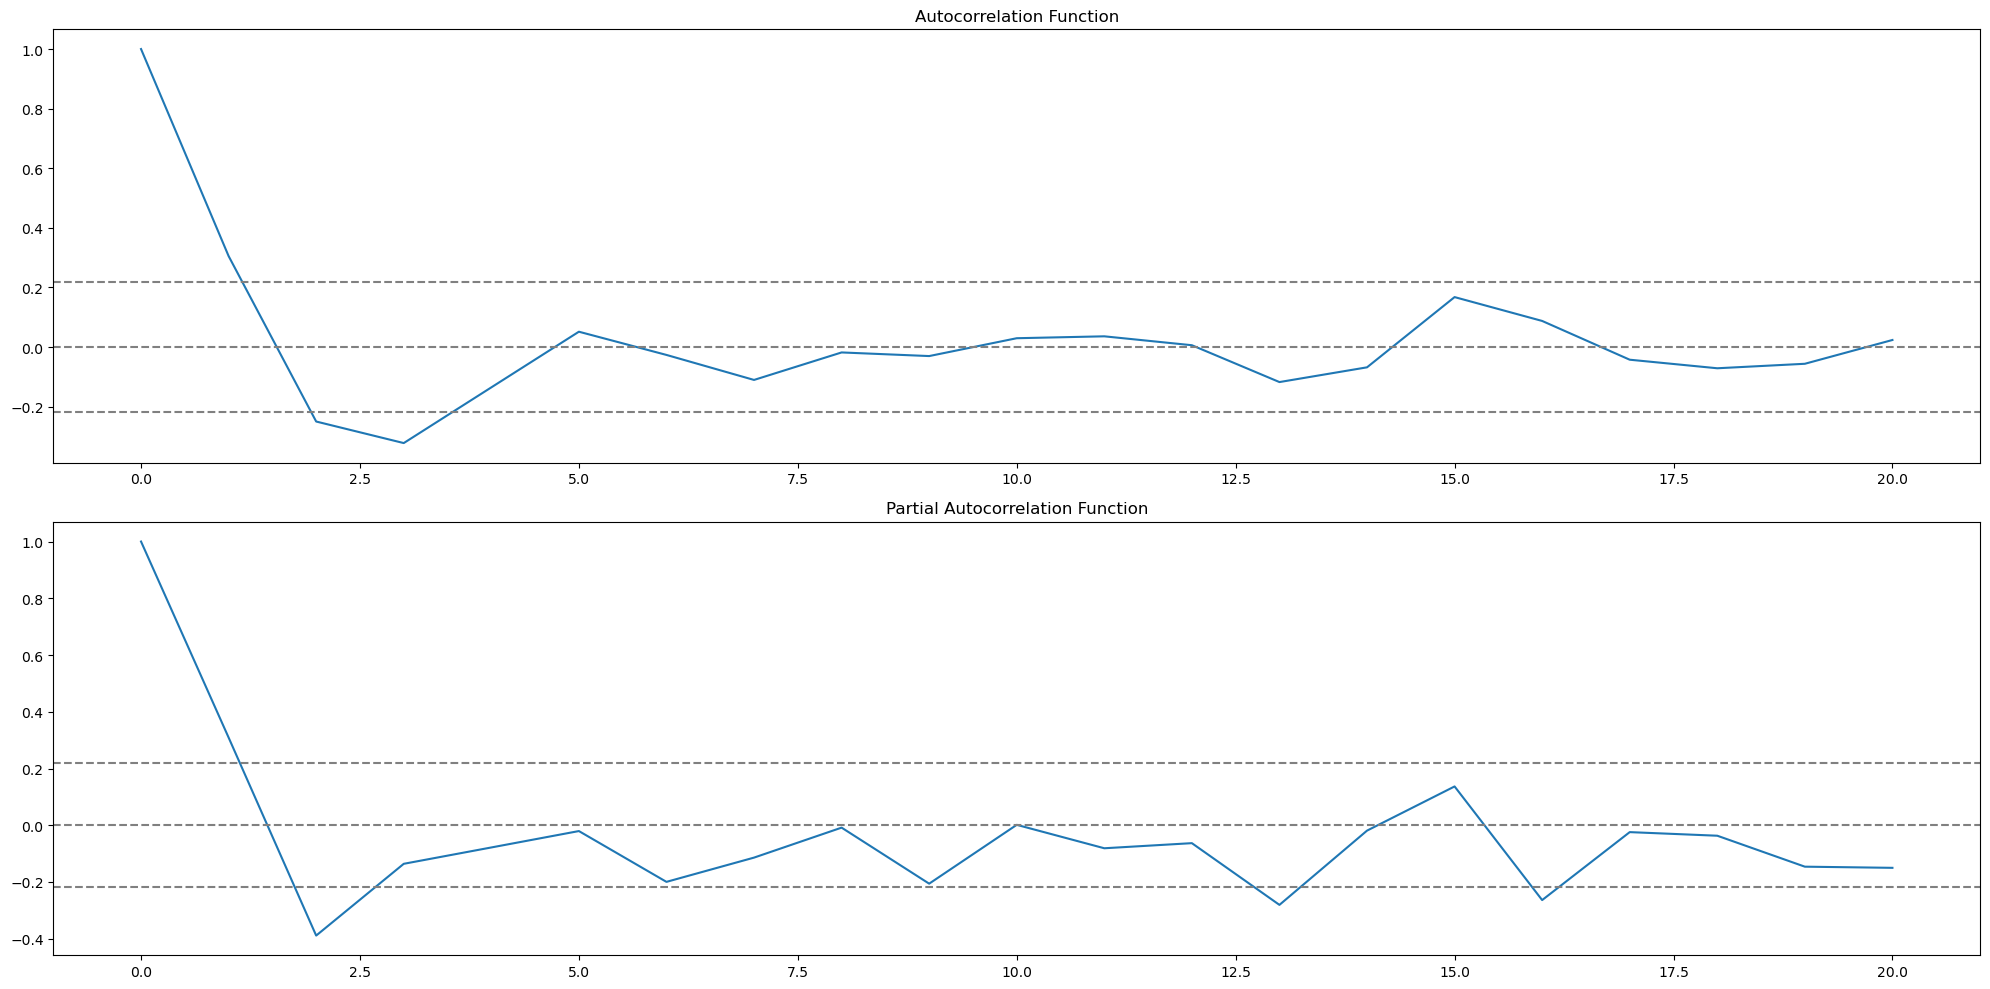

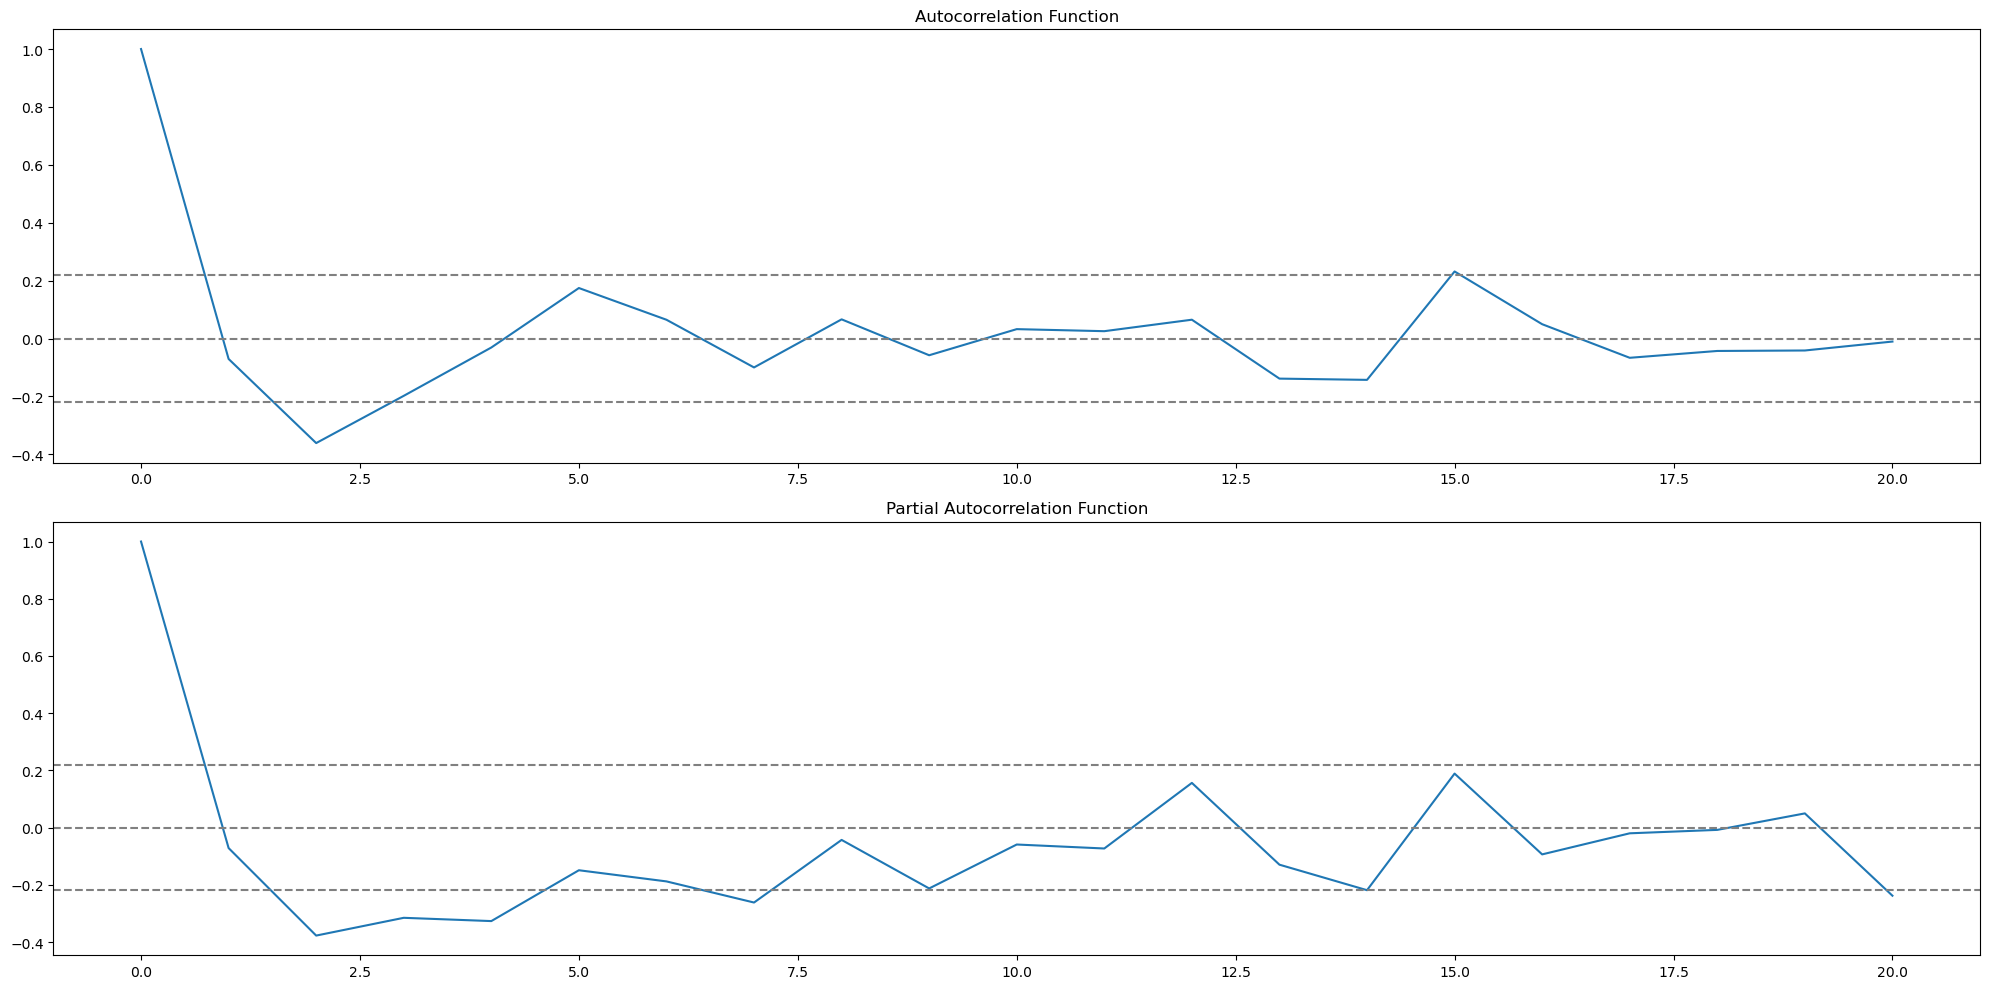

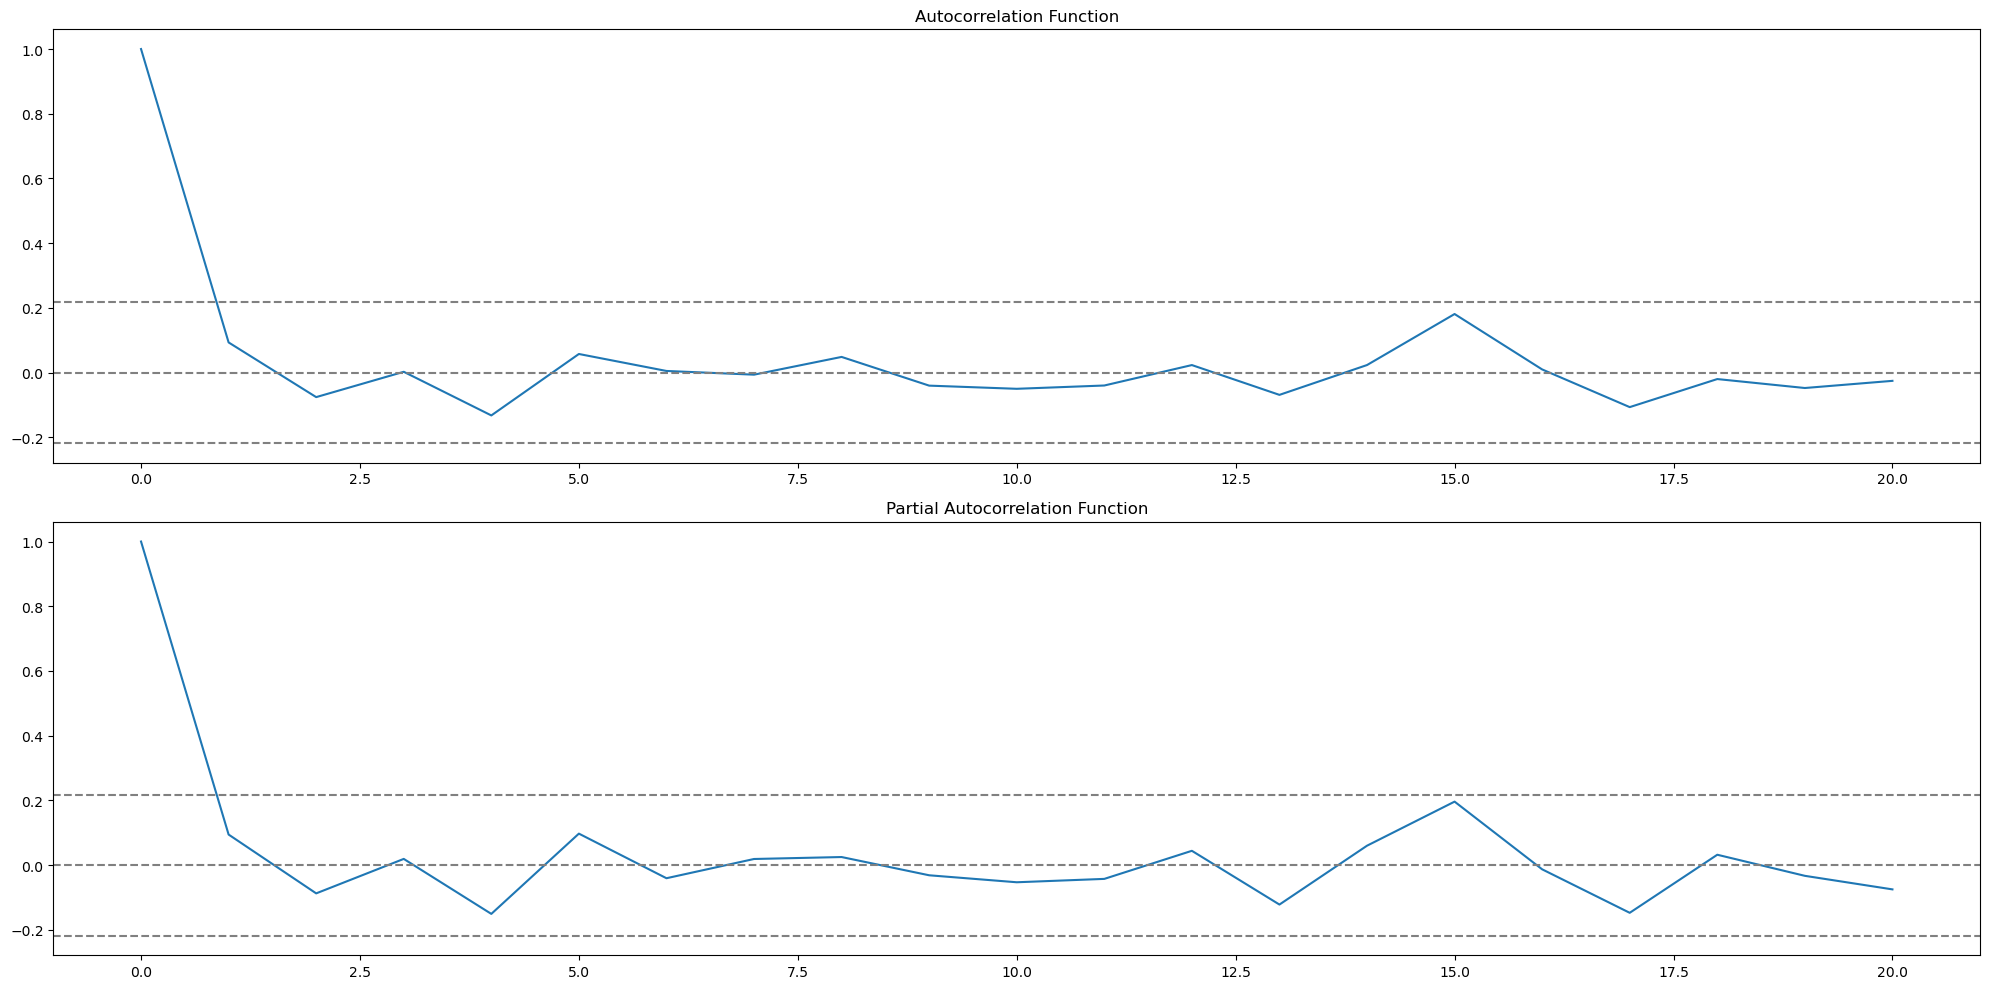

In [27]:
# Plot the ACF and PACF plots for the 3 stationary time series columns
plot_acf_pacf(df['sentiment_score_decomposed'])
plot_acf_pacf(df['sentiment_score_diff_decomposed'])
plot_acf_pacf(df['sentiment_score_diff'])

In [28]:
# Print the p-values of the 3 stationary time series columns
print(adfuller(df['sentiment_score_decomposed'])[1])
print(adfuller(df['sentiment_score_diff_decomposed'])[1])
print(adfuller(df['sentiment_score_diff'])[1])

1.795377147092933e-11
6.191999979136755e-08
1.8242541755263636e-12


In [29]:
# We are going to use the sentiment_score_decomposed column for the ARIMA model
df1 = df[['full_date', 'sentiment_score_decomposed']]

# Set the full_date column as the index
df1.set_index('full_date', inplace=True)

sentiment_score_decomposed    0
dtype: int64

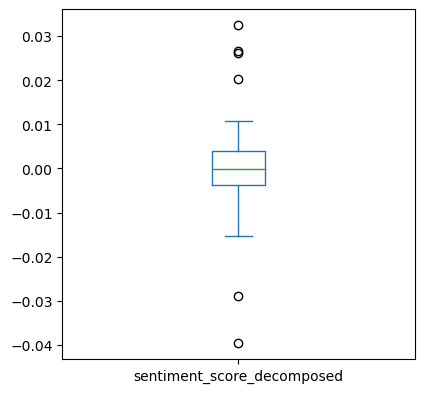

In [30]:
# Check the dataframe for outliers and missing values
df1.plot(kind='box', subplots=True, layout=(2,2), figsize=(10,10))
df1.isnull().sum()

In [31]:
# Normalise the dataframe
scaler = MinMaxScaler()
df1['sentiment_score_decomposed'] = scaler.fit_transform(df1['sentiment_score_decomposed'].values.reshape(-1,1))

C:\Users\Paul\AppData\Local\Temp\ipykernel_28100\3921684420.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['sentiment_score_decomposed'] = scaler.fit_transform(df1['sentiment_score_decomposed'].values.reshape(-1,1))


In [32]:
# Check the dataframe
print(len(df1))
print(round(len(df1)*.8))
print(len(df1) - round(len(df1)*.8))

81
65
16


In [33]:
df1.describe(include='all')

,sentiment_score_decomposed
count,81.000000
mean,0.548990
std,0.139348
min,0.000000
25%,0.496949
50%,0.548990
75%,0.605691
max,1.000000


(65, 1)
(16, 1)
Train dates : 2009-04-06 00:00:00 --- 2009-06-09 00:00:00  (n=65)
Test dates  : 2009-06-10 00:00:00 --- 2009-06-25 00:00:00  (n=16)


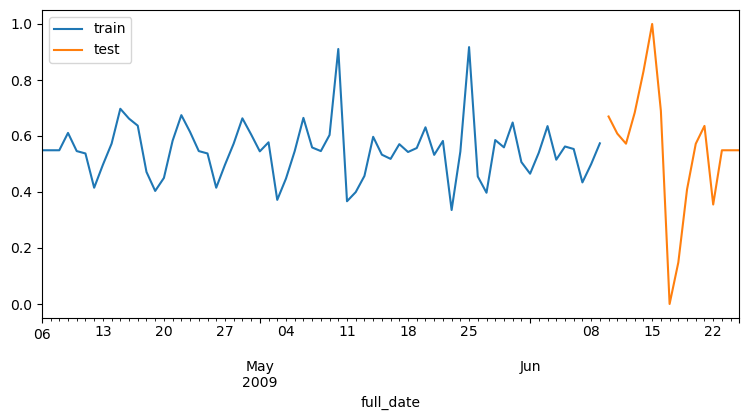

In [34]:
# Split data into train-test
# ==============================================================================
steps = 16
train = df1[:-steps]
test  = df1[-steps:]

print(train.shape)
print(test.shape)

print(f"Train dates : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Test dates  : {test.index.min()} --- {test.index.max()}  (n={len(test)})")

fig, ax=plt.subplots(figsize=(9, 4))
train['sentiment_score_decomposed'].plot(ax=ax, label='train')
test['sentiment_score_decomposed'].plot(ax=ax, label='test')
ax.legend()



In [35]:
model = ARIMA(train, order=(1,1,1), freq='D')
model_fit = model.fit()
print(model_fit.summary())

                                   SARIMAX Results                                    
Dep. Variable:     sentiment_score_decomposed   No. Observations:                   65
Model:                         ARIMA(1, 1, 1)   Log Likelihood                  52.445
Date:                        Sat, 04 Nov 2023   AIC                            -98.890
Time:                                22:22:12   BIC                            -92.414
Sample:                            04-06-2009   HQIC                           -96.339
                                 - 06-09-2009                                         
Covariance Type:                          opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0891      0.151      0.591      0.555      -0.207       0.385
ma.L1         -1.0000    214.012     -0.005      0.996    -420.456 

c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [36]:
# Tune the ARIMA model
# Create a function to find the best ARIMA model
def find_best_arima_model(train, p_values, d_values, q_values):
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    model = ARIMA(train, order=order)
                    model_fit = model.fit()
                    aic = model_fit.aic
                    if aic < best_score:
                        best_score, best_cfg = aic, order
                    print('ARIMA%s AIC=%.3f' % (order, aic))
                except:
                    continue
    print('Best ARIMA%s AIC=%.3f' % (best_cfg, best_score))
    return best_cfg


In [37]:
# Find the best ARIMA model
p_values = [0,1,2,4,6,8,10]
d_values = range(0,3)
q_values = range(0,3)
find_best_arima_model(train, p_values, d_values, q_values)

ARIMA(0, 0, 0) AIC=-107.261
ARIMA(0, 0, 1) AIC=-106.229


c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init

ARIMA(0, 0, 2) AIC=-127.796


c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will b

ARIMA(0, 1, 0) AIC=-67.118
ARIMA(0, 1, 1) AIC=-100.381
ARIMA(0, 1, 2) AIC=-99.685
ARIMA(0, 2, 0) AIC=-6.728
ARIMA(0, 2, 1) AIC=-58.883
ARIMA(0, 2, 2) AIC=-87.165


c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init

ARIMA(1, 0, 0) AIC=-105.608
ARIMA(1, 0, 1) AIC=-119.467


c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will b

ARIMA(1, 0, 2) AIC=-126.948
ARIMA(1, 1, 0) AIC=-69.691
ARIMA(1, 1, 1) AIC=-98.890


c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_

ARIMA(1, 1, 2) AIC=-99.104
ARIMA(1, 2, 0) AIC=-21.660
ARIMA(1, 2, 1) AIC=-60.939
ARIMA(1, 2, 2) AIC=-55.199
ARIMA(2, 0, 0) AIC=-112.872


c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init

ARIMA(2, 0, 1) AIC=-132.336


c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will b

ARIMA(2, 0, 2) AIC=-132.759
ARIMA(2, 1, 0) AIC=-78.181


c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starti

ARIMA(2, 1, 1) AIC=-105.411


c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will b

ARIMA(2, 1, 2) AIC=-119.951
ARIMA(2, 2, 0) AIC=-34.384
ARIMA(2, 2, 1) AIC=-68.620


c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 2, 2) AIC=-91.660
ARIMA(4, 0, 0) AIC=-115.218


c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init

ARIMA(4, 0, 1) AIC=-129.651


c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will b

ARIMA(4, 0, 2) AIC=-126.078
ARIMA(4, 1, 0) AIC=-85.264


c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will b

ARIMA(4, 1, 1) AIC=-106.892
ARIMA(4, 1, 2) AIC=-102.121
ARIMA(4, 2, 0) AIC=-48.832
ARIMA(4, 2, 1) AIC=-74.552


c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init

ARIMA(4, 2, 2) AIC=-91.218
ARIMA(6, 0, 0) AIC=-118.529


c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(6, 0, 1) AIC=-126.034


c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will b

ARIMA(6, 0, 2) AIC=-125.548
ARIMA(6, 1, 0) AIC=-89.124


c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(6, 1, 1) AIC=-108.944


c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will b

ARIMA(6, 1, 2) AIC=-114.970
ARIMA(6, 2, 0) AIC=-53.295


c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starti

ARIMA(6, 2, 1) AIC=-77.424


c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(6, 2, 2) AIC=-72.077
ARIMA(8, 0, 0) AIC=-117.871


c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will b

ARIMA(8, 0, 1) AIC=-116.612


c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will b

ARIMA(8, 0, 2) AIC=-122.497
ARIMA(8, 1, 0) AIC=-95.801


c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zer

ARIMA(8, 1, 1) AIC=-108.136


c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will b

ARIMA(8, 1, 2) AIC=-106.608
ARIMA(8, 2, 0) AIC=-63.456


c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zer

ARIMA(8, 2, 1) AIC=-83.025


c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(8, 2, 2) AIC=-80.201
ARIMA(10, 0, 0) AIC=-116.795


c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will b

ARIMA(10, 0, 1) AIC=-114.868


c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(10, 0, 2) AIC=-117.464
ARIMA(10, 1, 0) AIC=-98.770


c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to con

ARIMA(10, 1, 1) AIC=-106.507


c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(10, 1, 2) AIC=-104.416
ARIMA(10, 2, 0) AIC=-67.931


c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters fo

ARIMA(10, 2, 1) AIC=-85.063
ARIMA(10, 2, 2) AIC=-80.800
Best ARIMA(2, 0, 2) AIC=-132.759


c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 2)

In [38]:
# Create the ARIMA model using the best parameters
model = ARIMA(train, freq='D', order=(2,0,2))
model_fit = model.fit()
print(model_fit.summary())

c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                   SARIMAX Results                                    
Dep. Variable:     sentiment_score_decomposed   No. Observations:                   65
Model:                         ARIMA(2, 0, 2)   Log Likelihood                  72.380
Date:                        Sat, 04 Nov 2023   AIC                           -132.759
Time:                                22:22:28   BIC                           -119.713
Sample:                            04-06-2009   HQIC                          -127.612
                                 - 06-09-2009                                         
Covariance Type:                          opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5498      0.001   1001.545      0.000       0.549       0.551
ar.L1          1.2228      0.159      7.701      0.000       0.912 

c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


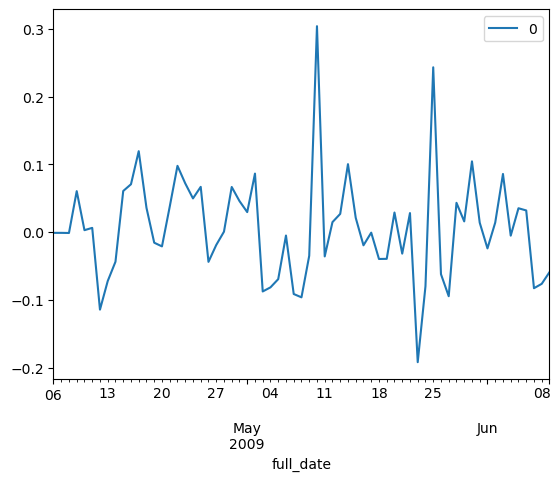

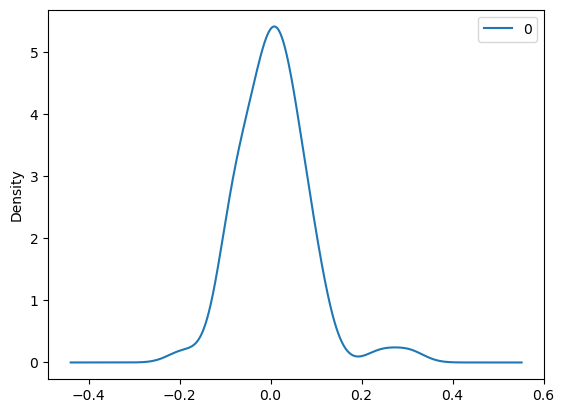

               0
count  65.000000
mean    0.006099
std     0.078121
min    -0.191526
25%    -0.039331
50%     0.000930
75%     0.043503
max     0.303976


In [39]:
# Plot the residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [40]:
# Generate predictions
predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1)


In [41]:
# Create a function to plot the predictions
def plot_predictions(predictions, test):
    plt.figure(figsize=(20,10))
    plt.plot(test, label='Actual')
    plt.plot(predictions, color='red', label='Predicted')
    plt.xlabel('Date')
    plt.ylabel('Sentiment Score')
    plt.title('Actual vs Predicted Sentiment Score')
    plt.legend()
    plt.show()
    
# Create a function to calculate the RMSE and R2 score
def calculate_metrics(test, predictions):
    rmse = np.sqrt(mean_squared_error(test, predictions))
    r2 = r2_score(test, predictions)
    print('The RMSE is', rmse)
    print('The R2 score is', r2)

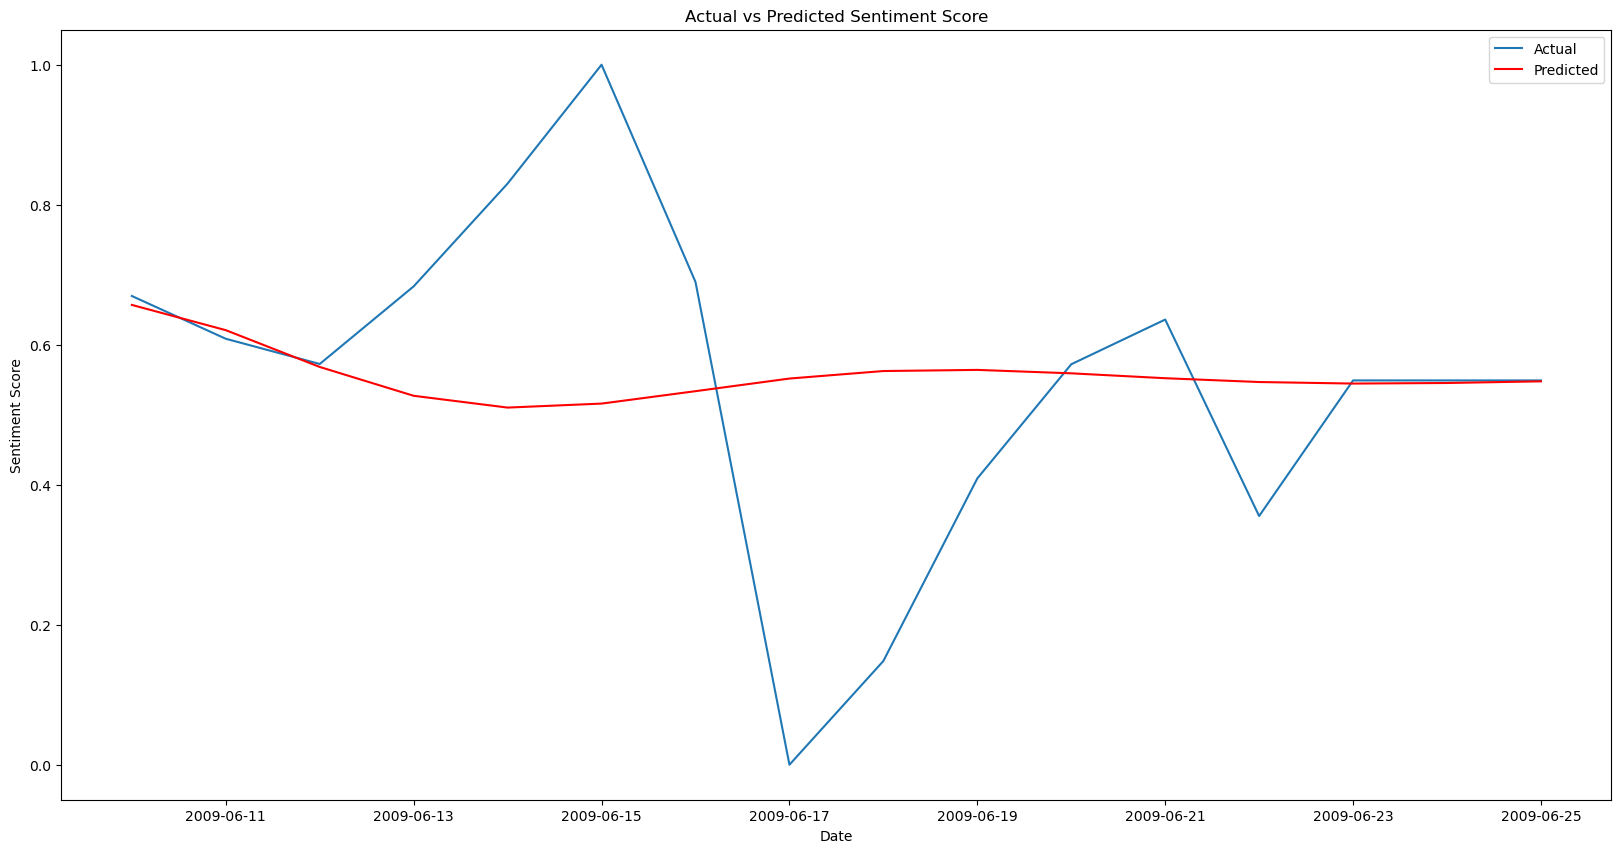

The RMSE is 0.2410563126921465
The R2 score is -45.2313936057646


In [42]:
# Plot the predictions against the actual values
plot_predictions(predictions, test)

# Calculate the RMSE, MAPE, MAE, and R2 score
calculate_metrics(predictions, test)

In [43]:
# Generate predictions for the entire dataset
predictions_full = model_fit.predict(start=0, end=len(df1) - 1)

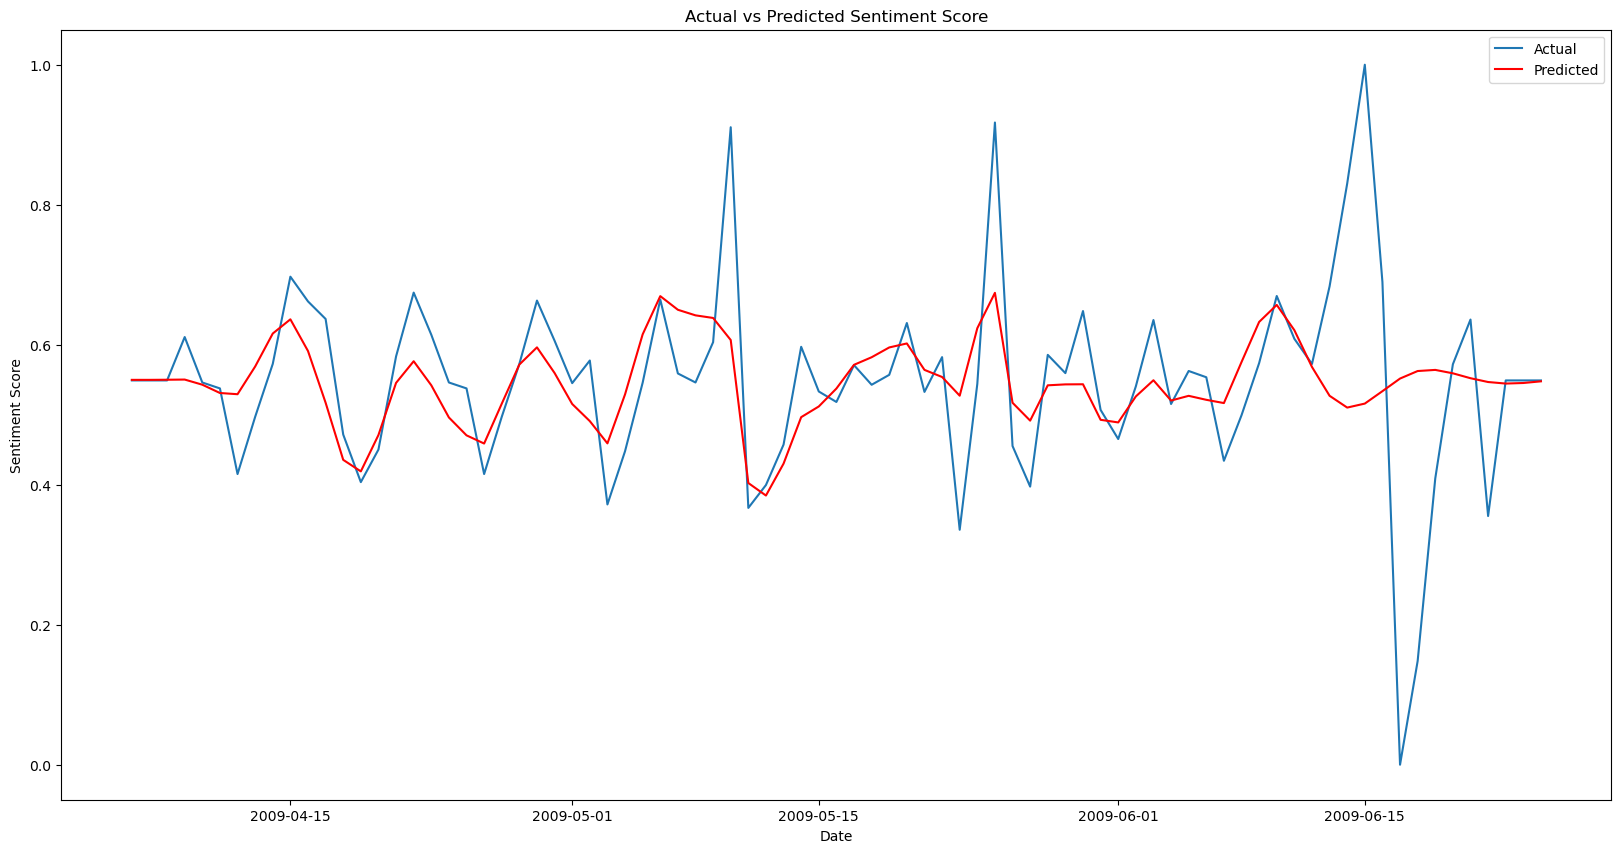

In [44]:
# Plot the entire time series with the predictions
plot_predictions(predictions_full, df1)

In [45]:
# Predict the sentiment score for the next 7 days
predictions_next_week = model_fit.predict(start=len(df1), end=len(df1) + 6)
predictions_next_week = scaler.inverse_transform(predictions_next_week.values.reshape(-1,1))
predictions_next_week = pd.DataFrame(predictions_next_week, columns=['sentiment_score_decomposed'])
predictions_next_week['full_date'] = pd.date_range(start=df1.index.max() + pd.Timedelta(days=1), end=df1.index.max() + pd.Timedelta(days=7))
predictions_next_week.set_index('full_date', inplace=True)
predictions_next_week

,sentiment_score_decomposed
full_date,
2009-06-26,0.000042
2009-06-27,0.000144
2009-06-28,0.000158
2009-06-29,0.000110
2009-06-30,0.000043
2009-07-01,-0.000009
2009-07-02,-0.000029


In [46]:
# Predict the sentiment score for the next 31 days
predictions_next_month = model_fit.predict(start=len(df1), end=len(df1) + 30)
predictions_next_month = scaler.inverse_transform(predictions_next_month.values.reshape(-1,1))
predictions_next_month = pd.DataFrame(predictions_next_month, columns=['sentiment_score_decomposed'])
predictions_next_month['full_date'] = pd.date_range(start=df1.index.max() + pd.Timedelta(days=1), end=df1.index.max() + pd.Timedelta(days=31))
predictions_next_month.set_index('full_date', inplace=True)
predictions_next_month

,sentiment_score_decomposed
full_date,
2009-06-26,0.000042
2009-06-27,0.000144
2009-06-28,0.000158
2009-06-29,0.000110
2009-06-30,0.000043
2009-07-01,-0.000009
2009-07-02,-0.000029
2009-07-03,-0.000021
2009-07-04,0.000002


In [47]:
# 3 months
predictions_next_3months = model_fit.predict(start=len(df1), end=len(df1) + 89)
predictions_next_3months = scaler.inverse_transform(predictions_next_3months.values.reshape(-1,1))
predictions_next_3months = pd.DataFrame(predictions_next_3months, columns=['sentiment_score_decomposed'])
predictions_next_3months['full_date'] = pd.date_range(start=df1.index.max() + pd.Timedelta(days=1), end=df1.index.max() + pd.Timedelta(days=90))
predictions_next_3months.set_index('full_date', inplace=True)
predictions_next_3months

,sentiment_score_decomposed
full_date,
2009-06-26,0.000042
2009-06-27,0.000144
2009-06-28,0.000158
2009-06-29,0.000110
2009-06-30,0.000043
...,...
2009-09-19,0.000022
2009-09-20,0.000022
2009-09-21,0.000022


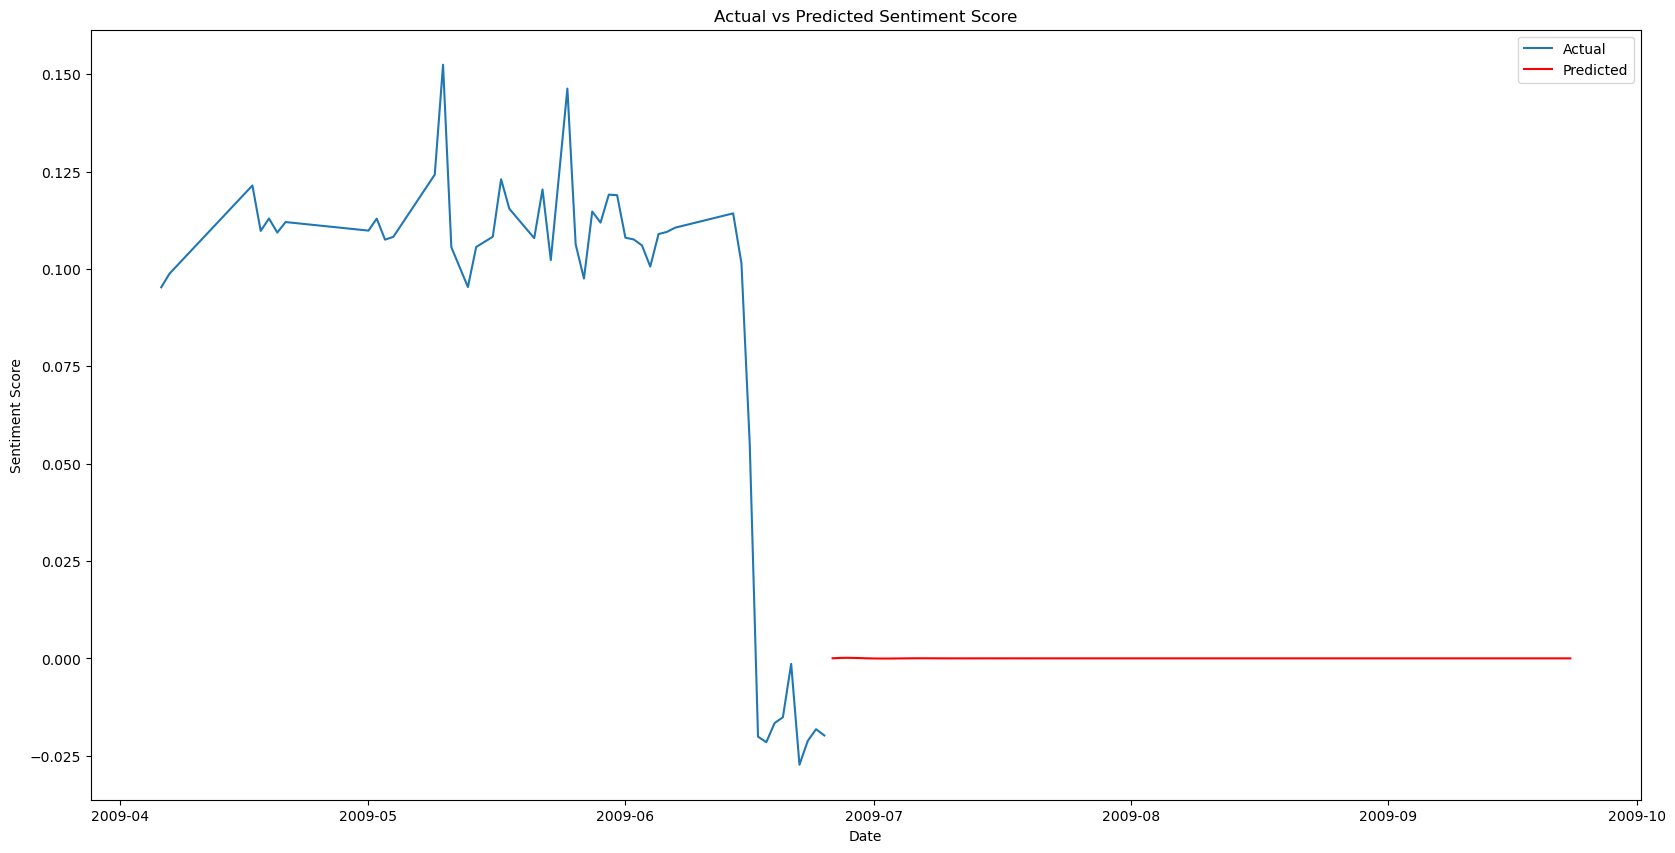

In [48]:
# Plot the entire time series with the predictions
plt.figure(figsize=(20,10))
plt.plot(df['full_date'], df['sentiment_score'], label='Actual')
plt.plot(predictions_next_3months, color='red', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Actual vs Predicted Sentiment Score')
plt.legend()
plt.show()

2. Forecaster

In [50]:
df2 = df[['full_date', 'sentiment_score_decomposed']]

In [51]:
# move the full_date column to the index and set the frequency to daily
df2.set_index('full_date', inplace=True)
df2.index.freq = 'D'

In [52]:
# Verify that a temporary index is complete
# ==============================================================================
(df2.index == pd.date_range(start=df2.index.min(),
                             end=df2.index.max(),
                             freq=df2.index.freq)).all()

True

Train dates : 2009-04-06 00:00:00 --- 2009-06-09 00:00:00  (n=65)
Test dates  : 2009-06-10 00:00:00 --- 2009-06-25 00:00:00  (n=16)


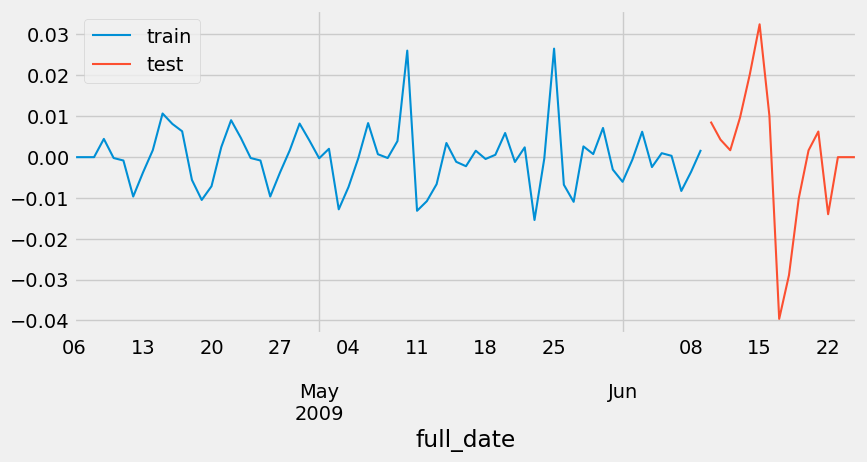

In [53]:
# Split data into train-test
# ==============================================================================
steps = 16
data_train = df2[:-steps]
data_test  = df2[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['sentiment_score_decomposed'].plot(ax=ax, label='train')
data_test['sentiment_score_decomposed'].plot(ax=ax, label='test')
ax.legend()

In [54]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
                )

forecaster.fit(y=data_train['sentiment_score_decomposed'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2009-04-06 00:00:00'), Timestamp('2009-06-09 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-11-04 22:22:33 
Last fit date: 2023-11-04 22:22:33 
Skforecast version: 0.10.1 
Python version: 3

In [55]:
# Predictions
# ==============================================================================
steps = 16
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2009-06-10    0.000897
2009-06-11    0.002168
2009-06-12    0.001013
2009-06-13    0.000124
2009-06-14   -0.003963
Freq: D, Name: pred, dtype: float64

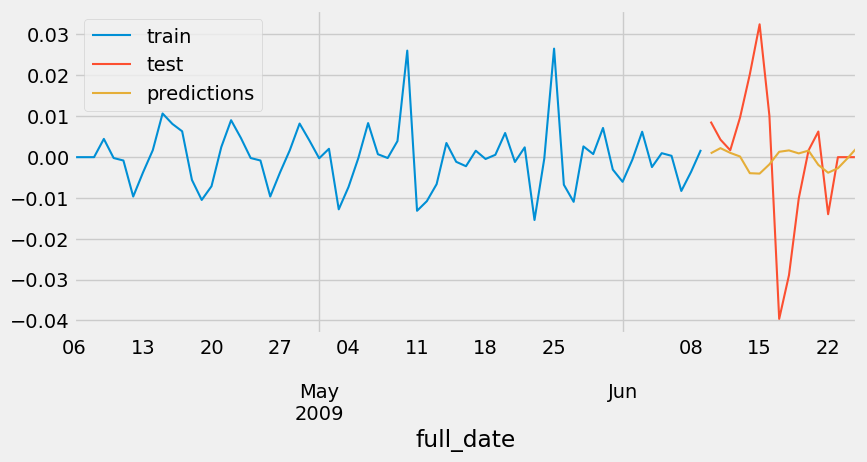

In [56]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['sentiment_score_decomposed'].plot(ax=ax, label='train')
data_test['sentiment_score_decomposed'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()

In [57]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['sentiment_score_decomposed'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 0.00032075896313430694


In [58]:
# Hyperparameter Grid search
# ==============================================================================
steps = 16
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [10, 20]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['sentiment_score_decomposed'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 12.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 3, 'n_estimators': 100}
  Backtesting metric: 9.053412322295647e-05



In [59]:
# Grid Search results
# ==============================================================================
results_grid

,lags,params,mean_squared_error,max_depth,n_estimators
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",0.000091,3,100
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",0.000091,10,100
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",0.000092,5,100
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",0.000094,3,500
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",0.000094,10,500
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",0.000094,5,500
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 500}",0.000096,3,500
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",0.000096,3,100
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.000097,5,100
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.000097,10,100


In [60]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=100, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )

forecaster.fit(y=data_train['sentiment_score_decomposed'])

In [61]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

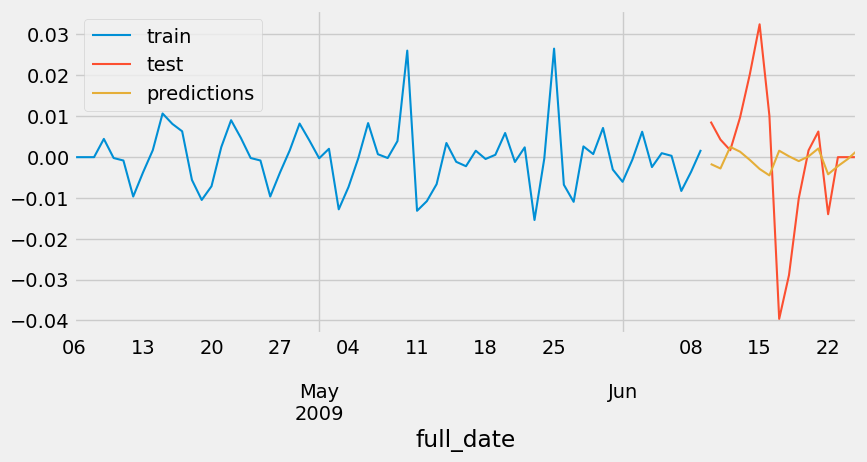

In [62]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['sentiment_score_decomposed'].plot(ax=ax, label='train')
data_test['sentiment_score_decomposed'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()

In [63]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['sentiment_score_decomposed'],
                y_pred = predictions
                )

print(f"Test error (mse): {error_mse}")

Test error (mse): 0.0003052690075724525


In [64]:
# Now we will use the entire dataset to train the model
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 20
             )

forecaster.fit(y=df2['sentiment_score_decomposed'])

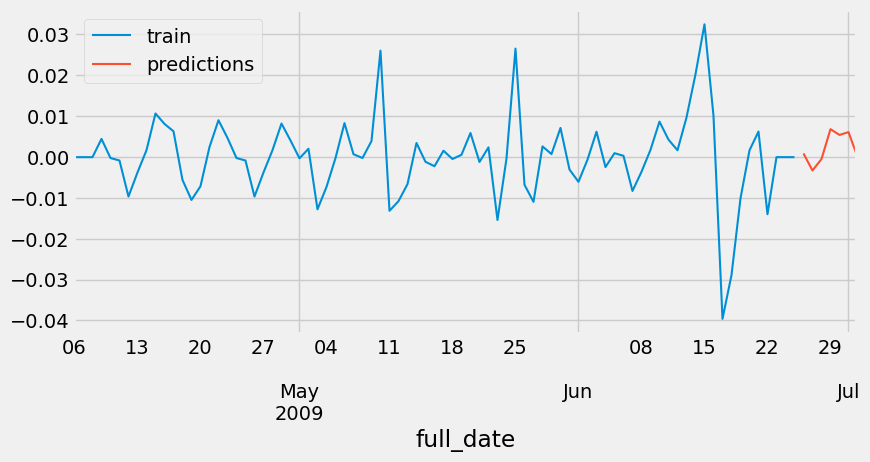

In [65]:
# Make 7 day predictions
# ==============================================================================
steps = 7
predictions7 = forecaster.predict(steps=steps)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
df2['sentiment_score_decomposed'].plot(ax=ax, label='train')
predictions7.plot(ax=ax, label='predictions')
ax.legend()


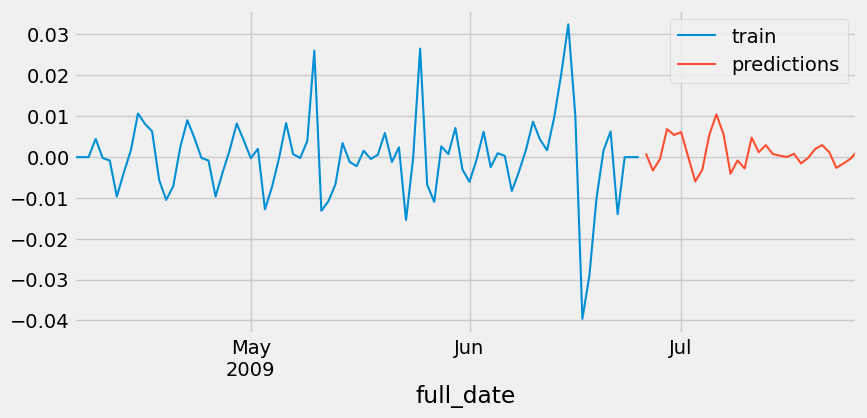

In [66]:
# Make 31 day predictions
# ==============================================================================
steps = 31
predictions31 = forecaster.predict(steps=steps)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
df2['sentiment_score_decomposed'].plot(ax=ax, label='train')
predictions31.plot(ax=ax, label='predictions')
ax.legend()


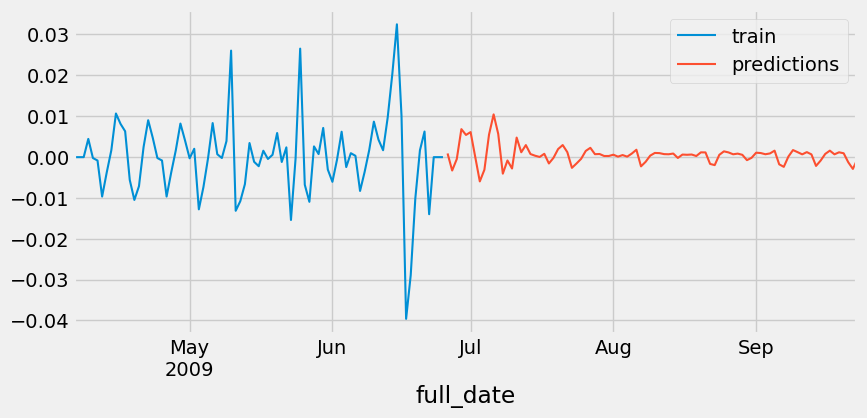

In [67]:
# Make 3 month predictions
# ==============================================================================
steps = 90
predictions90 = forecaster.predict(steps=steps)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
df2['sentiment_score_decomposed'].plot(ax=ax, label='train')
predictions90.plot(ax=ax, label='predictions')
ax.legend()


Dashboard

In [ ]:
# Create a dashboard to display the predictions

# select the Bootstrap stylesheet2 and figure template2 for the theme toggle here:
template_theme1 = "sketchy"
template_theme2 = "darkly"
url_theme1 = dbc.themes.SKETCHY
url_theme2 = dbc.themes.DARKLY

dbc_css = (
    "https://cdn.jsdelivr.net/gh/AnnMarieW/dash-bootstrap-templates@V1.0.1/dbc.min.css"
)

# Create the app
app = dash.Dash(__name__, external_stylesheets=[url_theme2, dbc_css])

# Load the figure templates for the Bootstrap themes
templates = ["bootstrap", "minty", "pulse", "flatly", "quartz", "cyborg", "darkly", "vapor"]
load_figure_template(templates)

# Create the layout
app.layout = dbc.Container([
    html.Div(
        children=[
            html.H1(
                children= "Sentiment Score Prediction"
                ),
            html.Div(
                children= "Select the time period to predict"
                ),
            dcc.Dropdown(
                id='dropdown', 
                options=[
                    {'label': '1 Week', 'value': '7'},
                    {'label': '1 Month', 'value': '31'},
                    {'label': '3 Months', 'value': '90'}
                    ], 
                value='7'
                ),
            dcc.Graph(
                id='graph', 
                figure='darkly'
                )
            ]
        )
    ],
                           fluid=True,
                           className="dbc dbc-ag-grid"
                           )

    
# Create the callback function
@app.callback(Output('graph', 'figure'), [Input('dropdown', 'value')])
def update_graph(value):
    if value == '7':
        predictions = predictions7
    elif value == '31':
        predictions = predictions31
    else:
        predictions = predictions90
    return {
        'data': [{
            'x': df2.index,
            'y': df2['sentiment_score_decomposed'],
            'name': 'Actual'
        }, {
            'x': predictions.index,
            'y': predictions,
            'name': 'Predicted'
        }],
        'layout': {
            'title': 'Sentiment Score Prediction'
        }
    }


# Run the app
if __name__ == '__main__':
    app.run_server(debug=False)
